In [1]:
import os
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

from sklearn.preprocessing import OneHotEncoder, StandardScaler
import joblib
from sklearn.metrics import roc_curve, auc, accuracy_score, f1_score, confusion_matrix

import comet_ml
from comet_ml import API

from helper_func import *

# 1. Download model

In [2]:
# Download a Registry Model:
api = API(api_key=os.environ.get('COMET_API_KEY'))

model = api.get_model(workspace=os.environ.get('workspace_name'),\
                      model_name='decision_tree')

model.download("1.0.0", output_folder="downloaded_models", expand=True)

# 2. Evaluate 2020 - regular season

### a. Evaluate

In [3]:
path_test_regular_csv = os.path.join("Dataset", "test_regular.csv")
path_test_playoff_csv = os.path.join("Dataset", "test_playoff.csv")


list_features = ['x-coordinate', 'y-coordinate', 'shot_distance', 'angle', 'isEmptyNet', 'n_friend',\
                 'n_oppose', 'last_event_type', 'is_rebound', 'attacking_zone_shot']

In [4]:
def Is_Shot_In_Attacking_Zone(x_coordinate_shot, attacking_side):

    if str(attacking_side).lower() == "left":
        x_coordinate_net = -89
        attacking_zone_range = -25
        return x_coordinate_net <= x_coordinate_shot <= attacking_zone_range
    elif str(attacking_side).lower() == "right":
        x_coordinate_net = 89
        attacking_zone_range = 25
        return  attacking_zone_range <= x_coordinate_shot <= x_coordinate_net
    else:
        return None

In [5]:
df_test = pd.read_csv(path_test_regular_csv)
df_test.dropna(inplace=True)

df_test['attacking_zone_shot'] = df_test.apply(lambda x: Is_Shot_In_Attacking_Zone(x['x-coordinate'], x['attackingSide']), axis=1)

X_test = df_test[list_features]
y_test = df_test['isgoal']

print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_test: (50353, 10)
Shape of y_test: (50353,)


In [6]:
decision_tree = joblib.load('downloaded_models/decision_tree.pkl')

In [7]:
# Inferencing on test set
y_test_pred = decision_tree.predict(X_test)
y_test_pred_proba_tree = decision_tree.predict_proba(X_test)[:, 1]

# Evaluate
accuracy = accuracy_score(y_test, y_test_pred)
fpr, tpr, _ = roc_curve(y_test, y_test_pred_proba_tree)
roc_auc = auc(fpr, tpr)

conf_matrix = confusion_matrix(y_test, y_test_pred)

print(f"Accuracy test set: {accuracy:.2f}")
print(f'ROC: {roc_auc}')
print("Confusion Matrix:")
print(conf_matrix)    

Accuracy test set: 0.90
ROC: 0.7472339215035373
Confusion Matrix:
[[44974   509]
 [ 4439   431]]


### b. Visualization

In [8]:
y_test_pred_proba_tree = decision_tree.predict_proba(X_test)[:, 1]

probs = [y_test_pred_proba_tree]
models = ['decision tree']

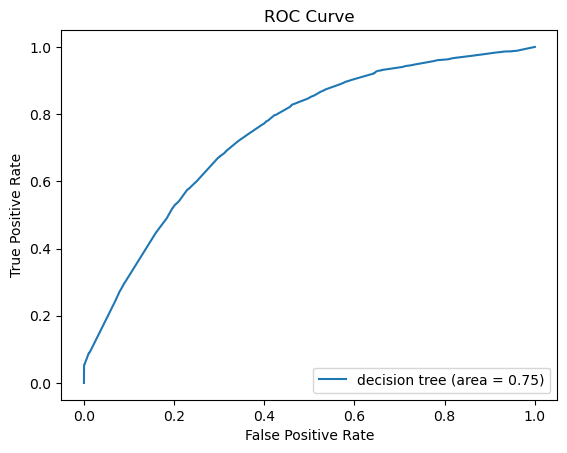

In [9]:
path_output_image = os.path.join("images", "evaluation", "roc_test_regular.jpg")
Visualize_ROC(models, probs, y_test, path_output_image)

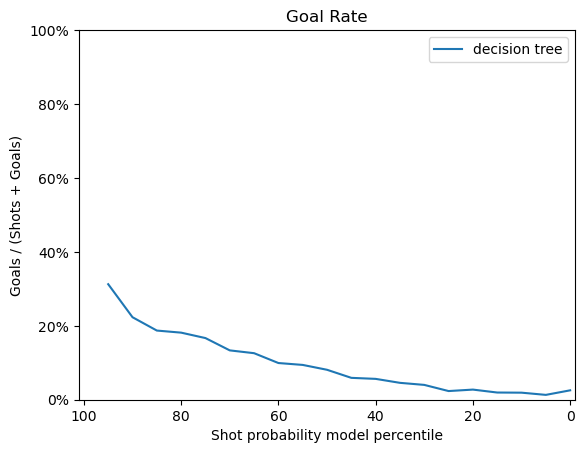

In [10]:
path_output_image = os.path.join("images", "evaluation", "goal_rate_test_regular.jpg")
Visualize_Goal_Rate(models, probs, y_test, path_output_image)

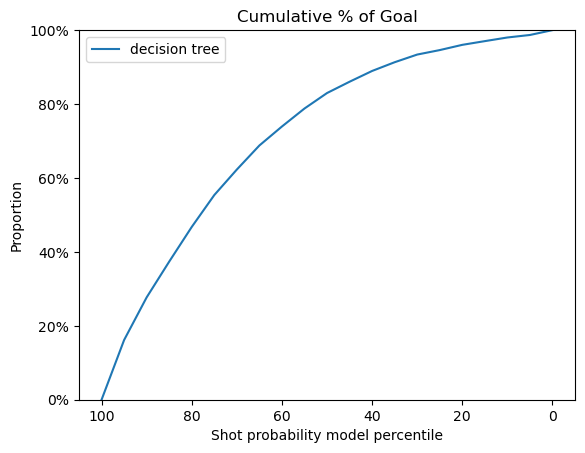

In [11]:
path_output_image = os.path.join("images", "evaluation", "cumulative_proportion_test_regular.jpg")
Visualize_Cumulative_Proportion(models, probs, y_test, path_output_image)

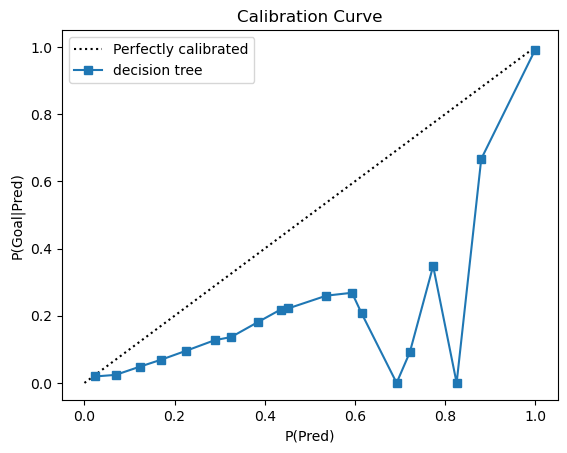

In [12]:
path_output_image = os.path.join("images", "evaluation", "calibration_test_regular.jpg")
Visualize_Calibration(models, probs, y_test, path_output_image)

# 3. Evaluate 2020 - playoff season

### a. Evaluation

In [13]:
df_test = pd.read_csv(path_test_playoff_csv)
df_test.dropna(inplace=True)

df_test['attacking_zone_shot'] = df_test.apply(lambda x: Is_Shot_In_Attacking_Zone(x['x-coordinate'], x['attackingSide']), axis=1)

X_test = df_test[list_features]
y_test = df_test['isgoal']

print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_test: (4745, 10)
Shape of y_test: (4745,)


In [14]:
# Inferencing on test set
y_test_pred = decision_tree.predict(X_test)
y_test_pred_proba_tree = decision_tree.predict_proba(X_test)[:, 1]

# Evaluate
accuracy = accuracy_score(y_test, y_test_pred)
fpr, tpr, _ = roc_curve(y_test, y_test_pred_proba_tree)
roc_auc = auc(fpr, tpr)

conf_matrix = confusion_matrix(y_test, y_test_pred)

print(f"Accuracy test set: {accuracy:.2f}")
print(f'ROC: {roc_auc}')
print("Confusion Matrix:")
print(conf_matrix)    

Accuracy test set: 0.91
ROC: 0.7476385560224201
Confusion Matrix:
[[4294   45]
 [ 369   37]]


### b. Visualization

In [15]:
y_test_pred_proba_tree = decision_tree.predict_proba(X_test)[:, 1]

probs = [y_test_pred_proba_tree]
models = ['decision tree']

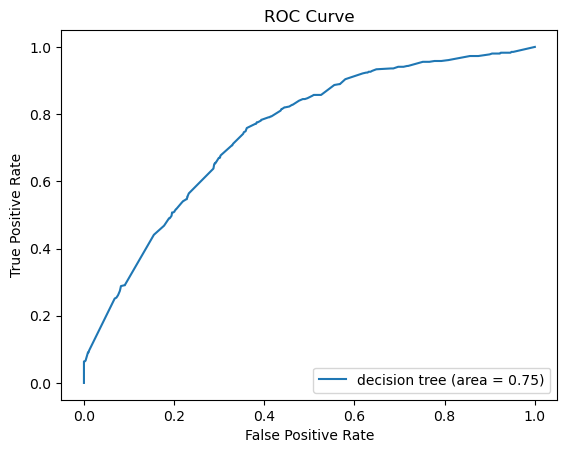

In [16]:
path_output_image = os.path.join("images", "evaluation", "roc_test_playoff.jpg")
Visualize_ROC(models, probs, y_test, path_output_image)

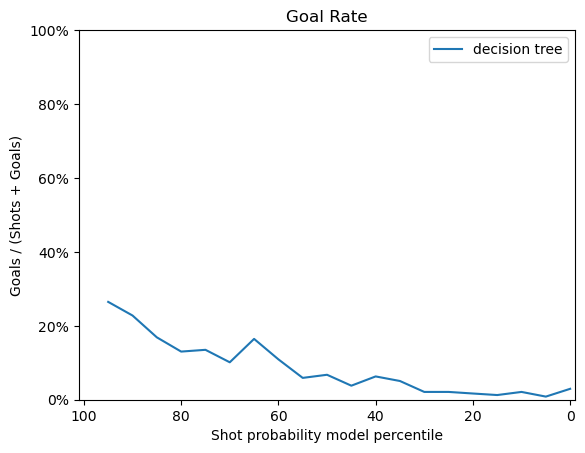

In [17]:
path_output_image = os.path.join("images", "evaluation", "goal_rate_test_playoff.jpg")
Visualize_Goal_Rate(models, probs, y_test, path_output_image)

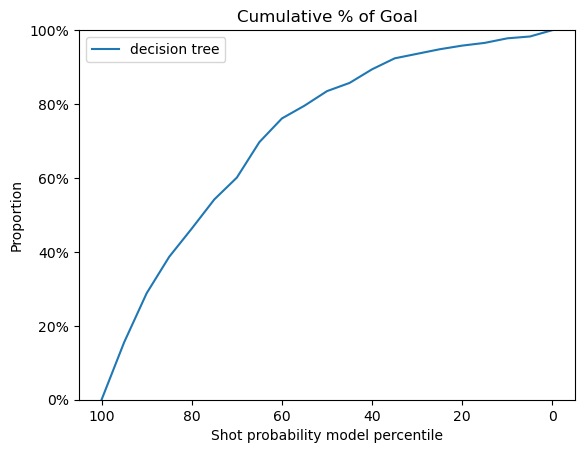

In [18]:
path_output_image = os.path.join("images", "evaluation", "cumulative_proportion_test_playoff.jpg")
Visualize_Cumulative_Proportion(models, probs, y_test, path_output_image)

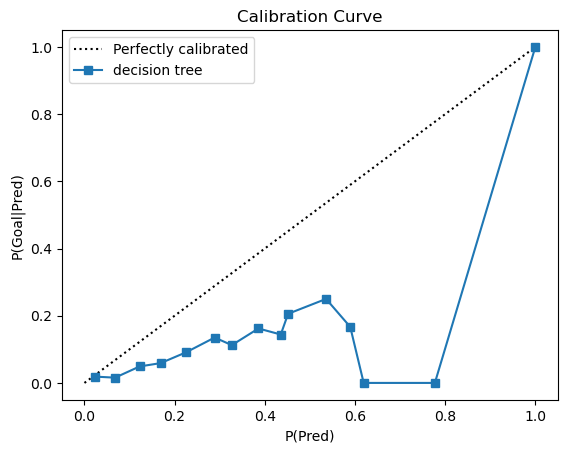

In [19]:
path_output_image = os.path.join("images", "evaluation", "calibration_test_playoff.jpg")
Visualize_Calibration(models, probs, y_test, path_output_image)